In [1]:
import os
import shutil

import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from utils import load_all_set, load_each_set, load_image

## seed value

In [2]:
IN_HEIGHT, IN_WIDTH = 224, 224

RESOURCE = "GPU"

RANDOM_SEED = 46

EPOCH = 100
BATCH_SIZE =  64
lr = 1e-4
EARLY_STOP = 20
WEIGHT_DECAY = 1e-3

"""
model name
-resnet50
-resnet50_pretrained
-vgg19
-vgg19_pretrained
"""
model_name = 'resnet50'

dir_name = f'result/{model_name}'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

model_path = f'{dir_name}/{model_name}.pth'
acc_path = f'{dir_name}/acc.png'
loss_path = f'{dir_name}/loss.png'
cm_path = f'{dir_name}/confusion_matrix.png'

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if RESOURCE == "CPU":
    device = torch.device("cpu")
    torch.manual_seed(RANDOM_SEED)
elif RESOURCE == "GPU":
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_SEED)

# Install dataset

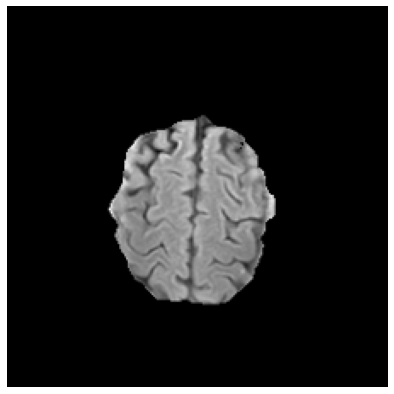

In [3]:
x_train, y_train, x_val, y_val, x_test, y_test = load_all_set()

plt.figure(figsize=(7,7))
plt.axis('off')
plt.imshow(x_train[0], cmap='gray')

In [4]:
class MyDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms = transforms
        self.data_num = len(xs)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            x = self.transforms(x)
        
        return x, y

In [5]:
model = models.resnet50(pretrained=False)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(nn.Linear(2048,1, bias=True),  nn.Sigmoid())

model = model.to(device)

criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)

print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Test

In [6]:
x_test, y_test = load_each_set('test')

transforms_test = transforms.Compose([
    transforms.ToTensor(),
])
dataset_test = MyDataset(xs=x_test, ys=y_test, transforms=transforms_test)

test_n = len(dataset_test)
print(test_n)

dataloader_test = DataLoader(dataset_test, batch_size=2*BATCH_SIZE)

model.load_state_dict(torch.load(model_path))
model.eval()

step = 0
batch_accuracy = 0
y_pred = []
with torch.no_grad():
    for inputs, targets in dataloader_test:
        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        b_outputs = outputs.squeeze().cpu().numpy().copy()
        b_targets = targets.squeeze().cpu().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)

        for i in b_outputs:
            y_pred.append([i])

        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

test_accuracy = batch_accuracy / step
y_pred = np.array(y_pred)

print(f'{100*test_accuracy:.2f}%')

2458
93.25%


In [7]:
incorrect_dir = f'{dir_name}/incorrect_mri/'

shutil.rmtree(incorrect_dir)

if not os.path.exists(incorrect_dir):
    os.makedirs(f'{incorrect_dir}/0')
    os.makedirs(f'{incorrect_dir}/1')

test_image_path = glob.glob('Dataset/test/0/' + '*.png') + glob.glob('Dataset/test/1/' + '*.png')

i = 0
for label, pred in zip(y_test, y_pred):
    if not label == pred:
        print(test_image_path[i])
        shutil.copy(test_image_path[i], f'{incorrect_dir}/{str(label[0])}/')
    i += 1

Dataset/test/0/3091.png
Dataset/test/0/1057.png
Dataset/test/0/1065.png
Dataset/test/0/4009.png
Dataset/test/0/3339.png
Dataset/test/0/2800.png
Dataset/test/0/1064.png
Dataset/test/0/1001.png
Dataset/test/0/2714.png
Dataset/test/0/3332.png
Dataset/test/0/523.png
Dataset/test/0/3069.png
Dataset/test/0/3061.png
Dataset/test/0/3625.png
Dataset/test/0/3908.png
Dataset/test/0/111.png
Dataset/test/0/3084.png
Dataset/test/0/3092.png
Dataset/test/0/3070.png
Dataset/test/0/510.png
Dataset/test/0/3085.png
Dataset/test/0/507.png
Dataset/test/0/2919.png
Dataset/test/0/3075.png
Dataset/test/0/3082.png
Dataset/test/0/505.png
Dataset/test/0/2413.png
Dataset/test/0/3337.png
Dataset/test/0/800.png
Dataset/test/0/2365.png
Dataset/test/0/3329.png
Dataset/test/0/1053.png
Dataset/test/0/106.png
Dataset/test/0/3003.png
Dataset/test/0/1063.png
Dataset/test/0/2781.png
Dataset/test/0/3323.png
Dataset/test/0/3818.png
Dataset/test/0/1925.png
Dataset/test/0/3078.png
Dataset/test/0/4200.png
Dataset/test/0/3093.png

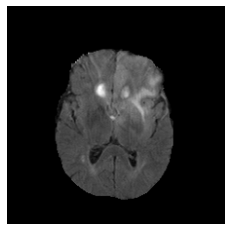

In [8]:
plt.axis('off')
plt.imshow(x_test[i-1], cmap='gray')